In [1]:
import pandas as pd
import numpy as np
from numpy import nan
import spacy
from scipy.stats import shapiro, kruskal, levene
import math
import re
import csv
from csv import reader # allows to open csv file to list of lists format
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from scipy import spatial
import itertools

import os
from collections import Counter

!pip install scikit_posthocs
!python -m spacy download nl_core_news_sm
import scikit_posthocs as sp
import nl_core_news_sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# connect colab to drive repository
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# set working directory to local file's location and print current working directory to see if it works
os.chdir('/content/gdrive/MyDrive/Thesis ADS/') # <- change string to local filepath
%pwd

'/content/gdrive/MyDrive/Thesis ADS'

##Pre-processing & Text Tokenization

To save RAM. Every news category is tokenized sperately and stored as csv-file. The csv-file is read merged in the dataframe.


In [ ]:
# load spacy Dutch stop word list to filter
nlp = nl_core_news_sm.load()

dutch_spacy_stopwords = spacy.lang.nl.stop_words.STOP_WORDS

In [ ]:
# tokenization
# the function originates from the group project of this year's Data Mining course. Co-authors are Sander Engelberts, Fausto de Lang and Jo Scheurs

def tokenize(df_column=None, processed_texts = [], remove_punctuation=True, 
             to_lowercase=True, stop_words=[], word_types=[], to_lemma=True):
    """
    Tokenizes the text entries in df_column using spacy tokenizer 
    and filters this on supplied arguments, or processes the already
    tokenized texts of processed_texts further
    
    Parameters
    ----------
    df_column : pandas Series object (default None)
        Series with texts that need to be tokenized.
        If None is supplied, then processed_texts needs to be given to process that
        one further using the other arguments instead of tokenizing df_column from the start
    processed_texts : list of list of str (default [])
        List of tokenized texts that need to be further processed using the other arguments.
        If this is supplied, then df_column needs to be None
    remove_punctuation : bool (default True)
        Boolean stating if punctuation needs to be removed from the tokenized texts
    to_lowercase : bool (default True)
        Boolean stating if the tokenized texts need to be lowercased
    stop_words : list of str (default [])
        List with (lowercased) stop words to remove from the tokenized texts,
        with the default being no words to remove
    word_types : list of str (default [])
        List with word types to keep from the tokenized texts, which have to be
        one or multiple of the POS tags of Spacy (e.g. see here for examples
        https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/)
    to_lemma : bool (default True)
        Boolean stating if the tokenized texts need to be lemmatized

        
    Returns
    -------
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column.
        This is a raw processed texts without taking the other arguments into
        account, such that still multiple different processing methods on the tokens can
        be done without needing to tokenize the full df_column anew
    processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column. 
        This is the fully processed texts that take all arguments into account
        to reach the desired tokenization result
    """
    # Preprocess dataset using Spacy tokenizer on texts in df_column, unless None is given,
    # then proceed by further processing the already supplied tokenized texts
    if df_column is not None:
        nlp = spacy.load("en_core_web_sm")
        processed_texts = [text for text in tqdm(nlp.pipe(df_column.values, disable=['ner', 'parser']),
                                                      total=len(df_column.values))]  
    
    # Remove spaces that are presented as an empty string 
    processed_texts = [[word for word in processed_text if not word.text.isspace()] 
                       for processed_text in processed_texts]
    
    raw_processed_texts = processed_texts.copy()
    
    # Remove punctuation if wanted
    if remove_punctuation:
        processed_texts = [[word for word in processed_text if not word.is_punct] 
                           for processed_text in processed_texts]
        
    # Remove the given stopwords # TODO [] empty list is standard
    if stop_words is not []:
        processed_texts = [[word for word in processed_text if not word.text in stop_words] 
                           for processed_text in processed_texts]
        
    # Filter on given word types, e.g. proper nouns ('PROPN'), verbs ('VERB'), nouns ('NOUN') and adjectives ('ADJ')  
    if word_types is not []:
        processed_texts = [[word for word in processed_text if word.pos_ in word_types] 
                           for processed_text in processed_texts]
    
    # Keep only lemmatized words if wanted
    if to_lemma:
        processed_texts = [[word.lemma_ for word in processed_text] 
                           for processed_text in processed_texts]
        
    # Lowercase the text if wanted. When it is lemmatized already, then each item is a string so directly
    # apply .lower() on it, and if it still is a token, then need to apply .text.lower().
    # Perform this as last step because the previous steps still require the spacy tokens
    if to_lowercase:
        processed_texts = [[word.lower() if isinstance(word, str) else word.text.lower() for word in processed_text] 
                           for processed_text in processed_texts]

    
    return raw_processed_texts, processed_texts

In [ ]:
# read NOS Data
nosnews = pd.read_csv('dutch-news-articles.csv')

# combine plural forms with apostrofe, change all punctuation to dot & combine words that are glued together with '-'
nosnews['content'] = nosnews['content'].replace('!','.').replace('?','.').replace("'", '').replace('-', '')

# store nosnews categories
cat_list = list(np.unique(list(nosnews.category)))

In [ ]:
# split every word in text string to get nr of words per article
nosnews['article_length'] = nosnews.content.apply(lambda text: len(text.split(' ')))

In [ ]:
# extract datset descirptives: total articles and average article length
print('Total articles within the dataset:', len(nosnews['article_length']))
print('Average article length:', np.mean(nosnews.article_length))

Total articles within the dataset: 239373
Average article length: 250.2935335229955


In [ ]:
#tokenize per news category and store in csv 'file' + str(category) + '.csv'
for cat in cat_list:
  #tokenize category content
  token_cat = tokenize(df_column = nosnews[nosnews.category == cat].content, to_lowercase = True, remove_punctuation = True, word_types = ['PROPN', 'VERB', 'NOUN', 'ADJ'], to_lemma=False, stop_words = dutch_spacy_stopwords)

  # write tokens/ list of lists to csv
  with open('nosnews_sections/file' + str(cat) + '.csv', 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(token_cat[1])

In [ ]:
for cat in cat_list:
  with open('nosnews_sections/file' + str(cat) + '.csv', 'r') as read_obj:
      # pass the file object to reader() to get the reader object
      csv_reader = reader(read_obj)
      # Pass reader object to list() to get a list of lists
      list_of_rows = list(csv_reader)
      # add column tokenized texts to dataframe
      nosnews.loc[nosnews.category == cat,'tokenized_text'] = list_of_rows
      # print lengths to see if all went well. If all lengths differ and sum tot total rows, everything seems ok.
      print(len(list_of_rows))

In [ ]:
# write dataframe including tokenized content column to csv
nosnews.to_csv('nos_news_complete.csv')

##Word2Vec embeddings

Train word embedding on entire corpus to vectorize tokens in texts.
Windowsize = 10,
Dimensions = 100,
Model = CBOW

In [ ]:
# read NOS data including tokenized content
nosnews = pd.read_csv('nos_news_complete.csv')

In [ ]:

tokenized_texts = [eval(list) for list in nosnews.tokenized_text.to_numpy()]
# generate word embedding with gensim & word2vec

tokenized_texts = tokenized_texts
# same as 'Guilty by Association: Using Word Embeddings to Measure Ethnic Stereotypes in News Coverage'
SIZE = 100 # dimensions of the embeddings
SG = 0 # whether to use skip-gram or CBOW (we use CBOW, this captures context)
WINDOW = 10 # the window size #5 in Kroon
N_WORKERS = 1 # number of workers to use
MIN_COUNT = 1

model = Word2Vec(size=SIZE,
                sg=SG,
                window=WINDOW, 
                min_count=MIN_COUNT,
                workers=N_WORKERS)

model.build_vocab(tokenized_texts)

model.train(tokenized_texts,
          total_examples=model.corpus_count,
          epochs=model.epochs) # grab some coffee while training

# save model
model.wv.save('NOS_CBOW_10W_100D.wordvectors')

#Apply NRC sentiment scores to tokenized text

In [ ]:
# load NRC lexicon translation file
NRC_lex = pd.read_excel("NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.xlsx")

# select columns: languages: English and Dutch + 8 affects
NRC_nl = NRC_lex[['Dutch (nl)','Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
       'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']].groupby('Dutch (nl)').agg('mean').reset_index()


In [ ]:
NRC_lex[NRC_lex['Dutch (nl)'] == 'verschrikkelijk']

,English (en),Afrikaans (af),Albanian (sq),Amharic (am),Arabic (ar),Armenian (hy),Azeerbaijani (az),Basque (eu),Belarusian (be),Bengali (bn),...,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
614,appalling,haglike,i tmerrshëm,አስደንጋጭ,مروع,սարսափելի,dəhşətli,appalling,жахлівы,আতঙ্কজনক,...,0,1,0,0,1,1,0,0,0,0
5234,frightful,vreeslike,i frikshëm,አስፈሪ,مخيف,սարսափելի,qorxunc,ikaragarri,жудасны,ভয়ঙ্কর,...,0,1,1,0,0,1,0,1,0,0
6077,horrible,aaklig,i tmerrshëm,አስከፊ,رهيب,սարսափելի,dəhşətli,izugarria,жудасны,ভয়ঙ্কর,...,0,1,1,0,1,1,0,0,0,0
6078,horribly,verskriklik,tmerrshëm,አስፈሪ,فظيعة,սարսափելիորեն,horribly,horribly,жахліва,ভয়ঙ্করভাবে,...,0,1,0,0,0,0,0,0,0,0
12649,terrible,verskriklike,i tmerrshëm,አስከፊ,رهيب,սարսափելի,qorxunc,terrible,жудасны,ভয়ানক,...,0,1,1,0,1,1,0,1,0,0
12652,terrific,geweldige,i frikshëm,ድንቅ,رائع,սարսափելի,dəhşətli,emanaldirik,надзвычайны,ভয়ঙ্কর,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
def NRC_sent_func(list_of_words):
  """ The function extracts the NRC emotion scores out of a list of tokenized text
    
    Parameters:
    -----------
    list_of_words: a list of strings
        The list of strings is preferrably a pre-processed and tokenized text.

    Returns
    -------
    Total_score_dict : a dictionary
      a dictionary with as keys the emotion and as value the NRC emotion score
    """


  x = pd.DataFrame()
  x = NRC_nl[NRC_nl['Dutch (nl)'].isin(list_of_words)]
  try:
    Total_score_dict = {'Anger': sum(x.Anger),
    'Anticipation': sum(x.Anticipation),
    'Disgust': sum(x.Disgust),
    'Fear': sum(x.Fear),
    'Joy': sum(x.Joy),
    'Negative': sum(x.Negative),
    'Positive': sum(x.Positive),
    'Sadness': sum(x.Sadness),
    'Surprise': sum(x.Surprise),
    'Trust': sum(x.Trust)}
  except:
    Total_score_dict = {'Anger': 0,
    'Disgust': 0,
    'Fear': 0,
    'Joy': 0,
    'Negative': 0,
    'Positive': 0,
    'Sadness': 0,
    'Surprise': 0,
    'Trust': 0}
  return Total_score_dict

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

# apply NRC sentiment lexicon on tokenized text
nosnews['NRC scores'] = nosnews['tokenized_text'].progress_apply(lambda content: NRC_sent_func(eval(content)))

  0%|          | 0/239373 [00:00<?, ?it/s]

In [ ]:
# transform column of dictionary to seperate df with keys as columns
df2 = pd.json_normalize(nosnews['NRC scores'])

# normalize emotions and polarity scores for every article
df2[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']] = df2[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']].div(df2[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']].sum(axis=1), axis=0)
df2[['Positive', 'Negative']] = df2[['Positive', 'Negative']].div(df2[['Positive', 'Negative']].sum(axis=1), axis=0)

# combine nosnews with normalized emotion score columns
nosnews = pd.concat([nosnews, df2], axis=1)

In [ ]:
nosnews

,Unnamed: 0,datetime,title,content,category,url,tokenized_text,NRC scores,Anger,Anticipation,Disgust,Fear,Joy,Negative,Positive,Sadness,Surprise,Trust
0,0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...,"['de', 'kerncentrale', 'litouwen', 'uur', 'geb...","{'Anger': 0.75, 'Anticipation': 0.5, 'Disgust'...",0.093750,0.062500,0.093750,0.093750,0.156250,0.333333,0.666667,0.312500,0.062500,0.125000
1,1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...,"['spanje', 'ingang', 'vandaag', 'voorzitter', ...","{'Anger': 0.0, 'Anticipation': 1.8333333333333...",0.000000,0.255814,0.139535,0.000000,0.139535,0.272727,0.727273,0.000000,0.000000,0.465116
2,2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...,"['vijf', 'werknemers', 'omstreden', 'amerikaan...","{'Anger': 2.5, 'Anticipation': 2.1666666666666...",0.185185,0.160494,0.172840,0.074074,0.074074,0.459459,0.540541,0.000000,0.000000,0.333333
3,3,2010-01-01 05:14:00,"Museumplein vol, minder druk in Rotterdam",Het Oud en Nieuwfeest op het Museumplein in Am...,Binnenland,https://nos.nl/artikel/126232-museumplein-vol-...,"['het', 'oud', 'nieuwfeest', 'museumplein', 'a...","{'Anger': 0.0, 'Anticipation': 2.5, 'Disgust':...",0.000000,0.326087,0.000000,0.043478,0.195652,0.194529,0.805471,0.043478,0.195652,0.195652
4,4,2010-01-01 05:30:00,Obama krijgt rapporten over aanslag,President Obama heeft de eerste rapporten gekr...,Buitenland,https://nos.nl/artikel/126236-obama-krijgt-rap...,"['president', 'obama', 'rapporten', 'gekregen'...","{'Anger': 0.3333333333333333, 'Anticipation': ...",0.037736,0.226415,0.150943,0.094340,0.113208,0.393939,0.606061,0.264151,0.000000,0.113208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239368,239368,2022-05-01 06:29:00,Biden steekt draak met zichzelf en Trump bij C...,In Washington is na twee jaar afwezigheid weer...,Buitenland,https://nos.nl/artikel/2427117-biden-steekt-dr...,"['washington', 'twee', 'jaar', 'afwezigheid', ...","{'Anger': 3.3333333333333335, 'Anticipation': ...",0.155039,0.046512,0.093023,0.124031,0.139535,0.450000,0.550000,0.139535,0.093023,0.209302
239369,239369,2022-05-01 07:08:00,"Dode, drie gewonden bij ongeluk in Oud Gastel",Bij een auto-ongeluk op de Standdaarbuitensedi...,Regionaal nieuws,https://nos.nl/artikel/2427118-dode-drie-gewon...,"['bij', 'auto', 'ongeluk', 'standdaarbuitensed...","{'Anger': 1.0, 'Anticipation': 0.6666666666666...",0.085714,0.057143,0.085714,0.342857,0.000000,0.857143,0.142857,0.257143,0.085714,0.085714
239370,239370,2022-05-01 07:16:00,Wekdienst 1/5: Opnieuw drukte Schiphol verwach...,Goedemorgen! Tennisser Botic van de Zandschulp...,Binnenland,https://nos.nl/artikel/2427119-wekdienst-1-5-o...,"['goedemorgen', 'tennisser', 'botic', 'zandsch...","{'Anger': 3.4, 'Anticipation': 6.15, 'Disgust'...",0.167488,0.302956,0.000000,0.108374,0.098522,0.535714,0.464286,0.137931,0.086207,0.098522
239371,239371,2022-05-01 08:39:00,"Naomi Judd (76) overleden, dag voor toetreding...",De Amerikaanse zangeres Naomi Judd is op 76-ja...,Buitenland,https://nos.nl/artikel/2427130-naomi-judd-76-o...,"['de', 'amerikaanse', 'zangeres', 'naomi', 'ju...","{'Anger': 1.75, 'Anticipation': 7.9, 'Disgust'...",0.039084,0.176438,0.022334,0.147031,0.178671,0.509225,0.490775,0.240089,0.092127,0.104225


In [ ]:
# write dataframe to csv, now including applied NRC scores
nosnews.to_csv('nosnews_complete_with_sentiment.csv')

#Research Question 1: high-threat & low-competence stereotype identification.

In [5]:
# load word embedding mdoel
modelNOS = KeyedVectors.load("NOS_CBOW_10W_100D.wordvectors")

In [ ]:
# store high-threat indicators
High_Threat_words = 'afperser, agent, agente, arrestant, arrestanten, autodief, autokraker, bajesklant, bandiet, bandieten, bankovervaller, bankrover, bedelaar, bedreiger, bende, bendeleden, bendeleider, bendelid, benden, bendes, beroepscrimineel, berovingen, beschieting, beul, boef, bolletjesslikker, bolletjesslikkers, bommenmaker, bordelen, brandstichter, brandstichters, corrupt, criminaliteit, crimineel, criminelen, cyberpesten, dader, daders, delinquent, delinquenten, dief, draaideurcrimineel, drugsbaas, drugsbaron, drugsbende, drugsbendes, drugscrimineel, drugsdealer, drugsdealers, drugsgebruikers, drugshandelaar, drugshandelaars, drugssmokkelaar, dubbelagent, fietsendief, gangster, gangsterbende, gedetineerde, gedetineerden, gegijzelden, gevangenbewaarders, gevangene, gevangenen, gevangenisbewaarder, gevangenissen, geweldsman, gijzelaar, gijzelaars, gijzelnemer, gijzelnemers, handlanger, hardrijder, hoofdagent, hoofdagente, hoofddader, hoofdverdachte, hooligan, hooligans, huurmoord, huurmoordenaar, illegalen, inbreker, indringer, jeugdbende, jeugdbendes, jeugddelinquent, kaper, kapers, kidnapper, kidnappers, kinderlokker, kindermisbruiker, kindermoordenaar, kindslaven, krijgsgevangenen, kruimeldief, kunstdief, ladykiller, lastpak, lastpost, liquidatie, loverboy, lovergirls, lustmoordenaar, maffia, maffiabaas, maffiosi, maffioso, maftabaas, massamoordenaar, massamoordenaars, mededader, medegedetineerde, medegevangene, medeplichtige, medeverdachte, mensenhandelaren, mensensmokkelaar, mensensmokkelaars, messentrekker, misdaden, misdadig, misdadiger, misdadigers, misdadigerwapenhandelaar, moordenaar, moordenaars, moordernaar, moordernaars, moordmachine, moordverdachte, motoragent, neerstak, neersteken, ontvoeringen, oplichter, overvaller, pedoftel, pedoftelen, piraten, plunderaar, plunderaars, politieagent, politieagente, politieagenten, politiecommandant, politiegeneraal, politiegewonde, politieman, politiemannen, politiemensen, politieofficier, politiepost, politierechercheur, politiestaat, politievrouw, poltiemensen, pyromaan, recidivist, relschopper, relschoppers, roofmoord, roofoverval, scherpschutter, schutter, seriemoordenaar, skinheads, slaaf, slachtoffers, slaven, sluipschutter, sluipschutters, smokkelaar, smokkelaars, snelheidsduivel, souteneur, stalker, straatbende, strafbaar, strafklacht, struikrover, tasjesdief, terreurgroep, terreurverdachte, terrorist, uitbuiting, vechtersbaas, veelpleger, veelplegers, veiligheidsagent, veiligheidsagenten, veiligheidspolitie, verdachte, verkrachter, vermisten, voortvluchtige, vreemdeling, vrouwenhandelaar, wapenhandelaar, winkeldief, winkeldievegge, wreker, wurgmoord, zakkenrollers, zedendelinquent, zedendeliquent, zelfmoordenaar, zwartrijder'
High_Threat_words = [word.strip(' ') for word in High_Threat_words.split(',')]

In [ ]:
# store low-status indicators
Low_Status_words = 'achterlijk, achterlijke, achterstanden, achterstandskinderen, achterstandsleerling, achterstandsleerlingen, achterstandswijken, achterstandwijken, achterstelling, alcoholicus, alcoholist, alcoholiste, alcoholisten, analfabeet, analfabete, analfabeten, armoedig, barbaars, bastaardzoon, bedelaar, bedelaars, bijstandsgerechtigden, bijstandsgerechtigen, boerenlul, dakloze, daklozen, dronkelap, druggebruikers, drugsgebruiker, drugsgebruikers, drugsrunners, drugstoeristen, drugsverslaafde, drugsverslaafden, hangjongere, hangjongeren, hoer, hoerenlopers, hulpbehoevend, hulpbehoevende, idiot, junk, junkers, junks, kansarme, kansarmen, kindertehuizen, krottenwijk, laaggeschoolde, laaggeschoolden, laagopgeleide, laagopgeleiden, loser, malloot, minderwaardig, nestbevuiler, nietsnut, onderklasse, onderontwikkeld, ongeletterde, ongeschoolde, overlastgevende, pooier, primitief, probleemjongeren, prostituee, prostituees, prostitutiebedrijven, reljongeren, schoolverlaters, slet, sloeber, sloebers, spijbelaar, spijbelen, straatarm, straatkinderen, straatprostitutie, sukkel, taalachterstand, tienermoeder, tienermoeders, uitkeringgerechtigden, uitkeringsgerechtigden, uitwas, verschoppelingen, verslaafde, verslaafden, weeskinderen, werkloos, werkloze, werklozen, werkschuwe, zwerver, zwervers'
Low_Status_words = [word.strip(' ') for word in Low_Status_words.split(',')]

In [ ]:
print('Out of the original low-status indicator list (len:', len(Low_Status_words),')', len([i for i in Low_Status_words if i in modelNOS.vocab]), 'appear in the corpus')
print('Out of the original High-Threat indicator list (len:', len(High_Threat_words),')',len([i for i in High_Threat_words if i in modelNOS.vocab]), 'appear in the corpus')

Out of the original low-status indicator list (len: 95 ) 60 appear in the corpus
Out of the original High-Threat indicator list (len: 208 ) 157 appear in the corpus


In [ ]:
# print words that exist in the original indicator list but did not exist in the corpus' vocab
l = list(set(High_Threat_words) - set([i for i in High_Threat_words if i in modelNOS.vocab]))
sorted(l)

['autokraker',
 'bajesklant',
 'bandieten',
 'bedelaar',
 'benden',
 'beroepscrimineel',
 'delinquent',
 'draaideurcrimineel',
 'fietsendief',
 'gangster',
 'gangsterbende',
 'gevangenisbewaarder',
 'geweldsman',
 'hardrijder',
 'hoofdagente',
 'huurmoord',
 'kinderlokker',
 'kunstdief',
 'ladykiller',
 'lastpost',
 'lovergirls',
 'lustmoordenaar',
 'maftabaas',
 'medegedetineerde',
 'mensensmokkelaar',
 'messentrekker',
 'misdadigerwapenhandelaar',
 'moordernaar',
 'moordernaars',
 'pedoftel',
 'pedoftelen',
 'plunderaar',
 'politiegeneraal',
 'politiegewonde',
 'politieofficier',
 'politierechercheur',
 'poltiemensen',
 'relschopper',
 'snelheidsduivel',
 'souteneur',
 'stalker',
 'straatbende',
 'strafklacht',
 'struikrover',
 'tasjesdief',
 'vechtersbaas',
 'winkeldievegge',
 'wreker',
 'wurgmoord',
 'zedendeliquent',
 'zwartrijder']

In [ ]:
# print words that exist in the original indicator list but did not exist in the corpus' vocab
l = list(set(Low_Status_words) - set([i for i in Low_Status_words if i in modelNOS.vocab]))
sorted(l)

['achterlijke',
 'achterstandskinderen',
 'achterstandsleerling',
 'alcoholicus',
 'alcoholist',
 'alcoholiste',
 'bastaardzoon',
 'bedelaar',
 'bijstandsgerechtigen',
 'boerenlul',
 'dronkelap',
 'druggebruikers',
 'drugsrunners',
 'hangjongere',
 'hoerenlopers',
 'idiot',
 'junkers',
 'kansarmen',
 'krottenwijk',
 'loser',
 'malloot',
 'minderwaardig',
 'nestbevuiler',
 'nietsnut',
 'ongeletterde',
 'prostitutiebedrijven',
 'reljongeren',
 'slet',
 'spijbelaar',
 'straatprostitutie',
 'tienermoeders',
 'uitkeringgerechtigden',
 'uitwas',
 'verschoppelingen',
 'werkschuwe']

In [ ]:
# read ethnic_name_list.csv, stores the most popular names per country
e_names = pd.read_csv('ethnic_name_list.csv')

# delete first entrance 'most-popular' and keep 50 next
e_names['NameList'] = e_names['NameList'].apply(lambda content: eval(content)[1:101])
e_names_df = e_names[['Country', 'NameList']]

# remove suriname from country list as retrieved names from forebears were only 39 and too typically Dutch
e_names_df = e_names_df[e_names_df['Country'] != 'suriname'].reset_index()

# remove names with double meaning
for i in range(len(e_names_df)):
  if 'most-popular' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('most-popular')
  if 'van' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('van')
  if 'ton' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('ton')
  if 'lul' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('lul')
  if 'margarita' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('margarita')
  if 'ben' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('ben')
  if 'adel' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('adel')
  if 'la' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('la')
  if 'mona' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('mona')


In [ ]:
# remove double elements from list
# similar remove names that occur also in other country lists

NameList_unique = []
for row in range(len(e_names_df)):
  NameList_unique.append(list(set(e_names.at[row, 'NameList']) - set([item for sublist in list(e_names[e_names['Country']!= e_names.at[row, 'Country']]['NameList']) for item in sublist])))
                                 
e_names_df['NameList_unique'] = NameList_unique
e_names_df['length unique names'] = [len(i) for i in NameList_unique]

In [ ]:
e_names_df

,index,Country,NameList,NameList_unique,length unique names
0,0,netherlands,"[jan, peter, hans, rob, henk, paul, jeroen, mo...","[jeroen, sander, mirjam, peter, edwin, marjole...",78
1,1,italy,"[maria, giuseppe, anna, giovanni, antonio, fra...","[giorgio, franca, giuliana, aldo, elena, filom...",90
2,2,greece,"[maria, georgios, dimitrios, ioannis, eleni, n...","[paraskevi, konstantin, evgenia, eleni, konsta...",95
3,3,iran,"[mohammad, fatemeh, zahra, ali, maryam, seyyed...","[tayebeh, azam, mansour, nasser, sahar, soheil...",82
4,4,morocco,"[mohamed, mohammed, fatima, ahmed, khadija, yo...","[hamza, ilham, oumaima, ibtissam, moulay, abde...",74
5,5,turkey,"[mehmet, fatma, mustafa, ayşe, ahmet, ali, emi...","[hanife, filiz, ahmet, sevgi, emre, mesut, ays...",91
6,7,syria,"[mohamed, ahmed, abdel, maara, hassan, ali, sa...","[nancy, ricardo, kenneth, rachel, harold, jenn...",21
7,8,somalia,"[mohamed, abdi, ahmed, fadumo, ali, hassan, ha...","[harran, nour, rana, shamalieh, sabah, jihad, ...",79
8,9,afghanistan,"[mohammad, abdul, bibi, gul, sayed, ghulam, fa...","[dahabo, nimco, warsame, mahamed, abshiro, sal...",78


In [ ]:
# read nosnews data & set columns tokenized_text as list, NRC scores as dict and sentiment columns to numeric
nosnews = pd.read_csv('nosnews_complete_with_sentiment.csv')
nosnews['tokenized_text'] = nosnews['tokenized_text'].apply(lambda text: eval(text))
nosnews['NRC scores'] = nosnews['NRC scores'].apply(lambda text: eval(text))
nosnews[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Negative', 'Positive', 'Sadness', 'Surprise', 'Trust']] = nosnews[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Negative', 'Positive', 'Sadness', 'Surprise', 'Trust']] .apply(pd.to_numeric)

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

# generate a flat list of rows containing all words of the corpus. Words can occure multiple times.
list_of_rows = [(text) for text in nosnews.tokenized_text.to_numpy()]
flat_list_of_rows = [item for sublist in list_of_rows for item in sublist]

# generate a flat list of rows containing all unique words of the corpus.
nosnews['unique_tokenized_text'] = nosnews.tokenized_text.progress_apply(lambda content: np.unique(content))
list_of_rows_unique = [text.tolist() for text in nosnews.unique_tokenized_text.to_numpy()]
flat_list_of_rows_unique = [item for sublist in list_of_rows_unique for item in sublist]


  0%|          | 0/239373 [00:00<?, ?it/s]

In [ ]:
# create lists to store frequency of names within whole corpus and article count
name_freqs_whole_corpus = []
name_freqs_articles = []

for country in tqdm(e_names_df.Country):
  name_list = [i for i in e_names_df[e_names_df.Country==country].NameList_unique][0]
  name_list = [i.lower() for i in name_list]
  for name in name_list:
    if name in modelNOS.vocab:
      # amount of time name occurs in all texts
      name_freqs_whole_corpus.append((country, name, flat_list_of_rows.count(name)))
      # number of unique texts that contain name
      # to do this you change every tokenized text to a unique token list, create a flat list again and count again.
      name_freqs_articles.append((country, name, flat_list_of_rows_unique.count(name)))


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# store frequencies in df, article frequencies that contain ethnic name (one article can only count as 1)
df = pd.DataFrame(name_freqs_articles, columns=['Country', 'Name', 'Frequency'])
df

,Country,Name,Frequency
0,netherlands,jeroen,1818
1,netherlands,sander,1046
2,netherlands,mirjam,169
3,netherlands,peter,3577
4,netherlands,edwin,542
...,...,...,...
273,afghanistan,abdi,29
274,afghanistan,asha,10
275,afghanistan,farah,58
276,afghanistan,nimo,1


In [ ]:
# store groupby to get total fequency per country
grouped_names_per_country = df.groupby(['Country']).agg(lambda x : x.sum() if x.dtype=='int64' else ','.join(x))
grouped_names_per_country.to_csv('plots_and_tables/grouped_names_per_country.csv')

In [7]:
# read just-stored grouped country-name frequency df
grouped_names_per_country = pd.read_csv('plots_and_tables/grouped_names_per_country.csv')
grouped_names_per_country

,Country,Name,Frequency
0,afghanistan,"sahra,bashir,daud,aden,muse,abdi,asha,farah,ni...",591
1,greece,"konstantin,eleni,andreas,olga,alexandros,sofia...",4186
2,iran,"mansour,nasser,sahar,hadi,akbar,neda,mahdi,asg...",1296
3,italy,"giorgio,franca,aldo,elena,fabio,silvia,paola,f...",3985
4,morocco,"hamza,ilham,yassine,tarik,abdelkader,abdelaziz...",3266
5,netherlands,"jeroen,sander,mirjam,peter,edwin,marjolein,arj...",65893
6,somalia,"nour,sabah,jihad,saleh,alaa,bab,yasser,tal,ham...",3589
7,syria,"nancy,ricardo,kenneth,rachel,harold,jennifer,s...",4218
8,turkey,"ahmet,mesut,aysel,yunus,orhan,salih,metin,selm...",1415


In [ ]:
# store frequencies in df, frequencies in whole corpus (one article can have more than 1 mention of ethnic name)
df_2 = pd.DataFrame(name_freqs_whole_corpus, columns=['Country', 'Name', 'Frequency'])

In [8]:
# a table that hold every name that is foundin the nos corpus per country
df_2.to_csv('plots_and_tables/names_included_per_country.csv')
pd.read_csv('plots_and_tables/names_included_per_country.csv')

,Unnamed: 0,Country,Name,Frequency
0,0,netherlands,jeroen,2119
1,1,netherlands,sander,1194
2,2,netherlands,mirjam,201
3,3,netherlands,peter,4361
4,4,netherlands,edwin,649
...,...,...,...,...
273,273,afghanistan,abdi,36
274,274,afghanistan,asha,27
275,275,afghanistan,farah,68
276,276,afghanistan,nimo,2


In [ ]:
grouped_names_per_country_whole_corpus = df_2.groupby(['Country']).agg(lambda x : x.sum() if x.dtype=='int64' else ','.join(x))
grouped_names_per_country_whole_corpus.to_csv('plots_and_tables/grouped_names_per_country_whole_corpus.csv')

In [9]:
# print out groupby dataframe of total mentions in whole corpus per ethnic group
grouped_names_per_country_whole_corpus = pd.read_csv('plots_and_tables/grouped_names_per_country_whole_corpus.csv')
grouped_names_per_country_whole_corpus


,Country,Name,Frequency
0,afghanistan,"sahra,bashir,daud,aden,muse,abdi,asha,farah,ni...",1167
1,greece,"konstantin,eleni,andreas,olga,alexandros,sofia...",5663
2,iran,"mansour,nasser,sahar,hadi,akbar,neda,mahdi,asg...",2197
3,italy,"giorgio,franca,aldo,elena,fabio,silvia,paola,f...",5332
4,morocco,"hamza,ilham,yassine,tarik,abdelkader,abdelaziz...",4931
5,netherlands,"jeroen,sander,mirjam,peter,edwin,marjolein,arj...",88120
6,somalia,"nour,sabah,jihad,saleh,alaa,bab,yasser,tal,ham...",5062
7,syria,"nancy,ricardo,kenneth,rachel,harold,jennifer,s...",5467
8,turkey,"ahmet,mesut,aysel,yunus,orhan,salih,metin,selm...",1779


In [ ]:
# Loop through all ethnic names and indicators, calculate similarity between all items and store average

# create empty dictionary to store average
ethnic_HT_scores = {}
ethnic_HT_vectors = {}
for row in tqdm(range(len(e_names_df))):
  # create list to store distances between ethnic names & indicators
  mean_mar_HT = []
  for indicator in High_Threat_words:
    for name in e_names_df.at[row, 'NameList']:
      if indicator in modelNOS.vocab and name in modelNOS.vocab:
        mean_mar_HT.append(1 - spatial.distance.cosine(modelNOS.wv[name], modelNOS.wv[indicator]))
        
  # ethnic_HT_scores dict stores mean, median standard deviation, variance and length of cosine scores, with country as key
  ethnic_HT_scores[str(e_names_df.at[row, 'Country'])] = (np.mean(mean_mar_HT), np.median(mean_mar_HT), np.std(mean_mar_HT), np.var(mean_mar_HT), len(mean_mar_HT))
  ethnic_HT_vectors[str(e_names_df.at[row, 'Country'])] = mean_mar_HT

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [ ]:
# create outgroups and ingroups vector by combining the countries on membership
outgroups_HT = ethnic_HT_vectors['afghanistan'] + ethnic_HT_vectors['iran'] + ethnic_HT_vectors['morocco'] + ethnic_HT_vectors['turkey'] + ethnic_HT_vectors['syria'] + ethnic_HT_vectors['somalia']
ingroups_HT = ethnic_HT_vectors['greece'] + ethnic_HT_vectors['italy']

In [ ]:
# store in dictionary
ethnic_HT_vectors['Outgroup'] = outgroups_HT
ethnic_HT_vectors['Ingroup'] = ingroups_HT

# calculate descriptives from vectors
ethnic_HT_scores['Outgroup'] = (np.mean(outgroups_HT), np.median(outgroups_HT), np.std(outgroups_HT), np.var(outgroups_HT), len(outgroups_HT))
ethnic_HT_scores['Ingroup'] = (np.mean(ingroups_HT), np.median(ingroups_HT), np.std(ingroups_HT), np.var(ingroups_HT), len(ingroups_HT))

In [ ]:
# write dictionary to df
HT_descriptives = pd.DataFrame.from_dict(ethnic_HT_scores, orient='index', columns = ['Mean', 'Median', 'Standard Deviation', 'Variance', 'Frequency'])
# round every number to 4 decimal places and store
HT_descriptives.round(4).to_csv('plots_and_tables/HT_descriptives.csv')

In [ ]:
# Loop through all ethnic names and indicators, calculate distance between all items and store average

# create empty dictionary to store average
ethnic_LS_scores = {}
ethnic_LS_vectors = {}
for row in tqdm(range(len(e_names_df))):
  # create list to store similarities between ethnic names & indicators
  mean_mar_LS = []
  for indicator in Low_Status_words:
    for name in e_names_df.at[row, 'NameList_unique']:
      if indicator in modelNOS.vocab and name in modelNOS.vocab:
        # 1- calculates distance, without calculates similarity
        mean_mar_LS.append(1 - spatial.distance.cosine(modelNOS.wv[name], modelNOS.wv[indicator]))

  # ethnic_LS_scores dict stores mean, median standard deviation, variance and length of cosine scores, with country as key
  ethnic_LS_scores[str(e_names_df.at[row, 'Country'])] = (np.mean(mean_mar_LS), np.median(mean_mar_LS), np.std(mean_mar_LS), np.var(mean_mar_LS), len(mean_mar_LS))
  ethnic_LS_vectors[str(e_names_df.at[row, 'Country'])] = mean_mar_LS

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
100%|██████████| 9/9 [00:00<00:00,  9.79it/s]


In [ ]:
# create outgroups and ingroups vector by combining the countries on membership
outgroups_LS = ethnic_LS_vectors['afghanistan'] + ethnic_LS_vectors['iran'] + ethnic_LS_vectors['morocco'] + ethnic_LS_vectors['turkey'] + ethnic_LS_vectors['syria'] + ethnic_LS_vectors['somalia']
ingroups_LS = ethnic_LS_vectors['greece'] + ethnic_LS_vectors['italy']

In [ ]:
# store in dictionary
ethnic_LS_vectors['Outgroup'] = outgroups_LS
ethnic_LS_vectors['Ingroup'] = ingroups_LS

# calculate descriptives from vectors
ethnic_LS_scores['Outgroup'] = (np.mean(outgroups_LS), np.median(outgroups_LS), np.std(outgroups_LS), np.var(outgroups_LS), len(outgroups_LS))
ethnic_LS_scores['Ingroup'] = (np.mean(ingroups_LS), np.median(ingroups_LS), np.std(ingroups_LS), np.var(ingroups_LS), len(ingroups_LS))

In [ ]:
# write to df and store
LS_descriptives = pd.DataFrame.from_dict(ethnic_LS_scores, orient='index', columns = ['Mean', 'Median', 'Standard Deviation', 'Variance', 'Frequency'])
LS_descriptives.round(4).to_csv('plots_and_tables/LS_descriptives.csv')

In [ ]:
# combine low-status and high-threat in one df
stereotype_df = pd.DataFrame.from_dict(ethnic_HT_scores, orient = 'index', columns = ['Mean HT', 'Median HT', 'Standard Deviation HT', 'Variance HT', 'Frequency HT'], dtype=np.float64)
stereotype_df_2 = pd.DataFrame.from_dict(ethnic_LS_scores, orient = 'index', columns = ['Mean LS', 'Median LS', 'Standard Deviation LS', 'Variance LS', 'Frequency LS'], dtype=np.float64)
stereotype_df = stereotype_df.join(stereotype_df_2)

In [ ]:
stereotype_df

,Mean HT,Median HT,Standard Deviation HT,Variance HT,Frequency HT,Mean LS,Median LS,Standard Deviation LS,Variance LS,Frequency LS
netherlands,0.427653,0.461645,0.251784,0.063395,15229.0,0.380976,0.423414,0.265004,0.070227,4680.0
italy,0.465259,0.512901,0.259482,0.067331,9263.0,0.370600,0.415601,0.266059,0.070787,3000.0
greece,0.399852,0.439495,0.271045,0.073465,3768.0,0.332958,0.365026,0.269852,0.072820,1320.0
iran,0.432669,0.457599,0.245754,0.060395,5495.0,0.257000,0.266264,0.278806,0.077733,1500.0
morocco,0.429676,0.491200,0.277580,0.077050,7065.0,0.307158,0.354594,0.282754,0.079950,1680.0
turkey,0.470129,0.508034,0.239947,0.057575,4396.0,0.356329,0.384601,0.257741,0.066430,1200.0
syria,0.440933,0.492713,0.277212,0.076846,6594.0,0.423131,0.460868,0.252483,0.063748,1200.0
somalia,0.447724,0.482774,0.250659,0.062830,4396.0,0.298120,0.339480,0.288122,0.083014,1800.0
afghanistan,0.440867,0.479276,0.263366,0.069362,6437.0,0.254499,0.259967,0.276468,0.076435,600.0
Outgroup,0.441888,0.484884,0.262208,0.068753,34383.0,0.316566,0.354694,0.280157,0.078488,7980.0


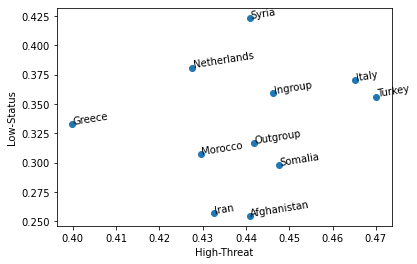

In [ ]:
import matplotlib.pyplot as plt

# plot averages of countries' and groups' ls and ht scores

annotations = [country.capitalize() for country in stereotype_df.index.to_list()]
fig, ax = plt.subplots()
ax.scatter(stereotype_df['Mean HT'], stereotype_df['Mean LS'])

plt.xlabel('High-Threat')
plt.ylabel('Low-Status')

theta = np.arctan(1.4)

for i, label in enumerate(annotations):
    plt.annotate(label, (stereotype_df['Mean HT'][i], stereotype_df['Mean LS'][i]), rotation=180.0*(1-theta))

plt.savefig('plots_and_tables/scatterplot_LS_HT.png')
plt.show()

In [ ]:
# Normality check per stereotype dimension per ethnic group

# for HT
shapiro_table_HT = pd.DataFrame()
for country in [['Native', ethnic_HT_vectors['netherlands']], ['Outgroups', outgroups_HT], ['Ingroups', ingroups_HT]]:
  print('The Shapiro-Wilk test result for', country[0], 'regarding High-Threat distance scores : ', shapiro(country[1]))
  dicti = {'Shapiro Statistic': [shapiro(country[1])[0]], 'p-value': [shapiro(country[1])[1]]}
  row_df = pd.DataFrame.from_dict(dicti)
  shapiro_table_HT = pd.concat([shapiro_table_HT, row_df], ignore_index=True)
shapiro_table_HT.index = ['Native', 'Outgroups', 'Ingroups']
shapiro_table_HT.to_csv('shapiro_table_HT.csv')

# for LS
shapiro_table_LS = pd.DataFrame()
for country in [['Native', ethnic_LS_vectors['netherlands']], ['Outgroups', outgroups_LS], ['Ingroups', ingroups_LS]]:
  print('The Shapiro-Wilk test result for', country[0], 'regarding Low-Status distance scores : ', shapiro(country[1]))
  dicti = {'Shapiro Statistic': [shapiro(country[1])[0]], 'p-value': [shapiro(country[1])[1]]}
  row_df = pd.DataFrame.from_dict(dicti)
  shapiro_table_LS = pd.concat([shapiro_table_LS, row_df], ignore_index=True)
shapiro_table_LS.index = ['Native', 'Outgroups', 'Ingroups']

shapiro_table_LS.to_csv('plots_and_tables/shapiro_table_LS.csv')


The Shapiro-Wilk test result for Native regarding High-Threat distance scores :  (0.9716283679008484, 0.0)
The Shapiro-Wilk test result for Outgroups regarding High-Threat distance scores :  (0.9587836861610413, 0.0)
The Shapiro-Wilk test result for Ingroups regarding High-Threat distance scores :  (0.9573614001274109, 0.0)
The Shapiro-Wilk test result for Native regarding Low-Status distance scores :  (0.9534978866577148, 3.3281538952738814e-36)
The Shapiro-Wilk test result for Outgroups regarding Low-Status distance scores :  (0.9772045016288757, 7.83731654722982e-34)
The Shapiro-Wilk test result for Ingroups regarding Low-Status distance scores :  (0.9703192710876465, 5.135253862877946e-29)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# perform kruskal-Wallis test to identify if any of the high-threat vectors significantly differ
print(kruskal(ethnic_HT_vectors['netherlands'], outgroups_HT, ingroups_HT))

KruskalResult(statistic=81.11109037250343, pvalue=2.4375330618678787e-18)


In [ ]:
# same goes for the low-status vectors
print(kruskal(ethnic_LS_vectors['netherlands'], outgroups_LS, ingroups_HT))

KruskalResult(statistic=1178.5111713615536, pvalue=1.2289966757007725e-256)


In [ ]:
# perform Dunn posthoc test with Bonferroni adjusted p-values and store in df
df_HT = sp.posthoc_dunn([ethnic_HT_vectors['netherlands'], outgroups_HT, ingroups_HT ], p_adjust = 'bonferroni')
df_HT.columns = ['Native', 'Outgroup', 'Ingroup']
df_HT.index = ['Native', 'Outgroup', 'Ingroup']
df_HT.round(4)

,Native,Outgroup,Ingroup
Native,1.0,0.0000,0.0000
Outgroup,0.0,1.0000,0.0802
Ingroup,0.0,0.0802,1.0000


In [ ]:
# perform Dunn posthoc test with Bonferroni adjusted p-values and store in df
df_LS = sp.posthoc_dunn([ethnic_LS_vectors['netherlands'], outgroups_LS, ingroups_LS], p_adjust = 'bonferroni')
df_LS.columns = ['Native', 'Outgroup', 'Ingroup']
df_LS.index = ['Native', 'Outgroup', 'Ingroup']
df_LS.round(4)

,Native,Outgroup,Ingroup
Native,1.0000,0.0,0.0001
Outgroup,0.0000,1.0,0.0000
Ingroup,0.0001,0.0,1.0000


#Research Question 2: Sentiment Analysis

In [ ]:
# read ethnic_name_list.csv, stores the most popular names per country
e_names = pd.read_csv('ethnic_name_list.csv')

# delete first entrance 'most-popular' and keep 50 next
e_names['NameList'] = e_names['NameList'].apply(lambda content: eval(content)[1:101])
e_names_df = e_names[['Country', 'NameList']]

# remove suriname from country list as retrieved names from forebears were only 39 and too typically Dutch
e_names_df = e_names_df[e_names_df['Country'] != 'suriname'].reset_index()

# remove names with double semantic meaning
for i in range(len(e_names_df)):
  if 'most-popular' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('most-popular')
  if 'van' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('van')
  if 'ton' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('ton')
  if 'lul' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('lul')
  if 'margarita' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('margarita')
  if 'ben' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('ben')
  if 'adel' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('adel')
  if 'la' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('la')
  if 'mona' in e_names_df.at[i, 'NameList']:
    e_names_df.at[i, 'NameList'].remove('mona')



In [ ]:
# remove double elements from list
# similar remove names that occur also in other country lists

NameList_unique = []
for row in range(len(e_names_df)):
  NameList_unique.append(list(set(e_names.at[row, 'NameList']) - set([item for sublist in list(e_names[e_names['Country']!= e_names.at[row, 'Country']]['NameList']) for item in sublist])))
                                 
e_names_df['NameList_unique'] = NameList_unique
e_names_df['length unique names'] = [len(i) for i in NameList_unique]

In [13]:
# read nosnews data & set columns tokenized_text as list, NRC scores as dict and sentiment columns to numeric
nosnews = pd.read_csv('nosnews_complete_with_sentiment.csv')
nosnews['tokenized_text'] = nosnews['tokenized_text'].apply(lambda text: eval(text))
nosnews['NRC scores'] = nosnews['NRC scores'].apply(lambda text: eval(text))
nosnews[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Negative', 'Positive', 'Sadness', 'Surprise', 'Trust']] = nosnews[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Negative', 'Positive', 'Sadness', 'Surprise', 'Trust']] .apply(pd.to_numeric)

In [ ]:
nosnews

,Unnamed: 0,Unnamed: 0.1,datetime,title,content,category,url,tokenized_text,NRC scores,Anger,Anticipation,Disgust,Fear,Joy,Negative,Positive,Sadness,Surprise,Trust
0,0,0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...,"[de, kerncentrale, litouwen, uur, gebruik, ges...","{'Anger': 0.75, 'Anticipation': 0.5, 'Disgust'...",0.093750,0.062500,0.093750,0.093750,0.156250,0.333333,0.666667,0.312500,0.062500,0.125000
1,1,1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...,"[spanje, ingang, vandaag, voorzitter, eu, de, ...","{'Anger': 0.0, 'Anticipation': 1.8333333333333...",0.000000,0.255814,0.139535,0.000000,0.139535,0.272727,0.727273,0.000000,0.000000,0.465116
2,2,2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...,"[vijf, werknemers, omstreden, amerikaanse, bev...","{'Anger': 2.5, 'Anticipation': 2.1666666666666...",0.185185,0.160494,0.172840,0.074074,0.074074,0.459459,0.540541,0.000000,0.000000,0.333333
3,3,3,2010-01-01 05:14:00,"Museumplein vol, minder druk in Rotterdam",Het Oud en Nieuwfeest op het Museumplein in Am...,Binnenland,https://nos.nl/artikel/126232-museumplein-vol-...,"[het, oud, nieuwfeest, museumplein, amsterdam,...","{'Anger': 0.0, 'Anticipation': 2.5, 'Disgust':...",0.000000,0.326087,0.000000,0.043478,0.195652,0.194529,0.805471,0.043478,0.195652,0.195652
4,4,4,2010-01-01 05:30:00,Obama krijgt rapporten over aanslag,President Obama heeft de eerste rapporten gekr...,Buitenland,https://nos.nl/artikel/126236-obama-krijgt-rap...,"[president, obama, rapporten, gekregen, misluk...","{'Anger': 0.3333333333333333, 'Anticipation': ...",0.037736,0.226415,0.150943,0.094340,0.113208,0.393939,0.606061,0.264151,0.000000,0.113208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239368,239368,239368,2022-05-01 06:29:00,Biden steekt draak met zichzelf en Trump bij C...,In Washington is na twee jaar afwezigheid weer...,Buitenland,https://nos.nl/artikel/2427117-biden-steekt-dr...,"[washington, twee, jaar, afwezigheid, white, h...","{'Anger': 3.3333333333333335, 'Anticipation': ...",0.155039,0.046512,0.093023,0.124031,0.139535,0.450000,0.550000,0.139535,0.093023,0.209302
239369,239369,239369,2022-05-01 07:08:00,"Dode, drie gewonden bij ongeluk in Oud Gastel",Bij een auto-ongeluk op de Standdaarbuitensedi...,Regionaal nieuws,https://nos.nl/artikel/2427118-dode-drie-gewon...,"[bij, auto, ongeluk, standdaarbuitensedijk, br...","{'Anger': 1.0, 'Anticipation': 0.6666666666666...",0.085714,0.057143,0.085714,0.342857,0.000000,0.857143,0.142857,0.257143,0.085714,0.085714
239370,239370,239370,2022-05-01 07:16:00,Wekdienst 1/5: Opnieuw drukte Schiphol verwach...,Goedemorgen! Tennisser Botic van de Zandschulp...,Binnenland,https://nos.nl/artikel/2427119-wekdienst-1-5-o...,"[goedemorgen, tennisser, botic, zandschulp, st...","{'Anger': 3.4, 'Anticipation': 6.15, 'Disgust'...",0.167488,0.302956,0.000000,0.108374,0.098522,0.535714,0.464286,0.137931,0.086207,0.098522
239371,239371,239371,2022-05-01 08:39:00,"Naomi Judd (76) overleden, dag voor toetreding...",De Amerikaanse zangeres Naomi Judd is op 76-ja...,Buitenland,https://nos.nl/artikel/2427130-naomi-judd-76-o...,"[de, amerikaanse, zangeres, naomi, judd, leeft...","{'Anger': 1.75, 'Anticipation': 7.9, 'Disgust'...",0.039084,0.176438,0.022334,0.147031,0.178671,0.509225,0.490775,0.240089,0.092127,0.104225


In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

# create subsets that include all the articles that contain any of the ethnic name of the belonging country
netherlands_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[0, 'NameList_unique']]))] #.NameList.iloc[0]]))]
netherlands_nos.to_csv('ethnic_subsets/netherlands_nosnews.csv')
italy_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[1, 'NameList_unique']]))] #.NameList.iloc[1]]))]
italy_nos.to_csv('ethnic_subsets/italy_nosnews.csv')
greece_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[2, 'NameList_unique']]))] #.NameList.iloc[1]]))]
greece_nos.to_csv('ethnic_subsets/greece_nosnews.csv')
iran_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[3, 'NameList_unique']]))] #.NameList.iloc[1]]))]
iran_nos.to_csv('ethnic_subsets/iran_nosnews.csv')
morocco_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[4, 'NameList_unique']]))] #.NameList.iloc[1]]))]
morocco_nos.to_csv('ethnic_subsets/morocco_nosnews.csv')
turkey_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[5, 'NameList_unique']]))] #.NameList.iloc[1]]))]
turkey_nos.to_csv('ethnic_subsets/turkey_nosnews.csv')
syria_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[6, 'NameList_unique']]))] #.NameList.iloc[1]]))]
syria_nos.to_csv('ethnic_subsets/syria_nosnews.csv')
somalia_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[7, 'NameList_unique']]))] #.NameList.iloc[1]]))]
somalia_nos.to_csv('ethnic_subsets/somalia_nosnews.csv')
afghanistan_nos = nosnews[nosnews.tokenized_text.progress_apply(lambda tokenized_text: any([token in tokenized_text for token in e_names_df.at[8, 'NameList']]))] #.NameList.iloc[1]]))]
afghanistan_nos.to_csv('ethnic_subsets/afghanistan_nosnews.csv')

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

  0%|          | 0/239373 [00:00<?, ?it/s]

In [ ]:
# create outgroups and ingroups df by combining countries df on membership
outgroups_df = pd.concat([iran_nos, morocco_nos, turkey_nos, syria_nos, somalia_nos, afghanistan_nos], ignore_index=True, axis=0)
outgroups_df.to_csv('ethnic_subsets/outgroups_nosnews.csv')
ingroups_df = pd.concat([italy_nos, greece_nos])
ingroups_df.to_csv('ethnic_subsets/ingroups_nosnews.csv')

In [14]:
# read just created df's
outgroups_df = pd.read_csv('ethnic_subsets/outgroups_nosnews.csv', index_col = 0)
ingroups_df = pd.read_csv('ethnic_subsets/ingroups_nosnews.csv', index_col = 0)
netherlands_nos = pd.read_csv('ethnic_subsets/netherlands_nosnews.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

<Figure size 432x288 with 0 Axes>

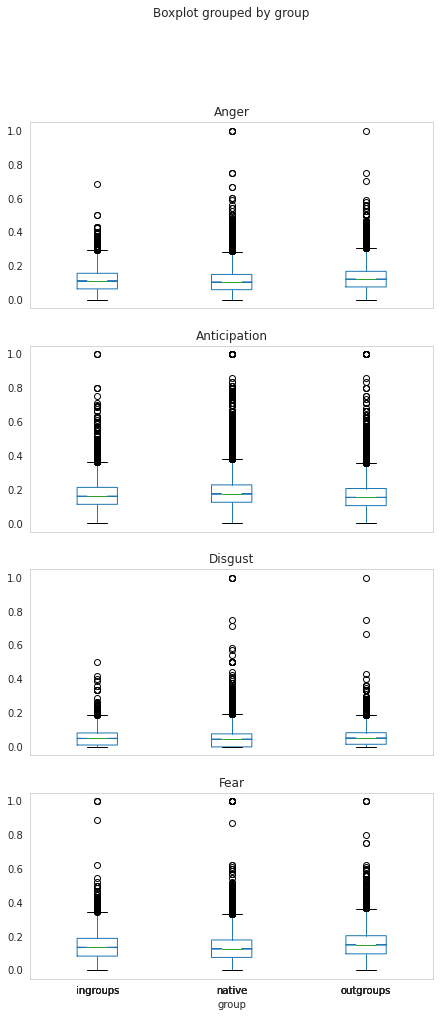

In [ ]:
import matplotlib.pyplot as plt

# create boxplots for first 4 emotions
outgroups_df['group'] = 'outgroups'
ingroups_df['group'] = 'ingroups'
netherlands_nos['group'] = 'native'

myFig = plt.figure()
grouped_df = pd.concat([netherlands_nos, outgroups_df, ingroups_df])

boxplot = grouped_df.boxplot(column=['Anger',
       'Anticipation', 'Disgust', 'Fear'], by='group', notch=True,
                     layout=(5, 1), figsize = (7, 20) ,return_type='axes', grid=False)

plt.savefig("plots_and_tables/Sentiment_bPlots_first.png", format="png")
myFig.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

<Figure size 432x288 with 0 Axes>

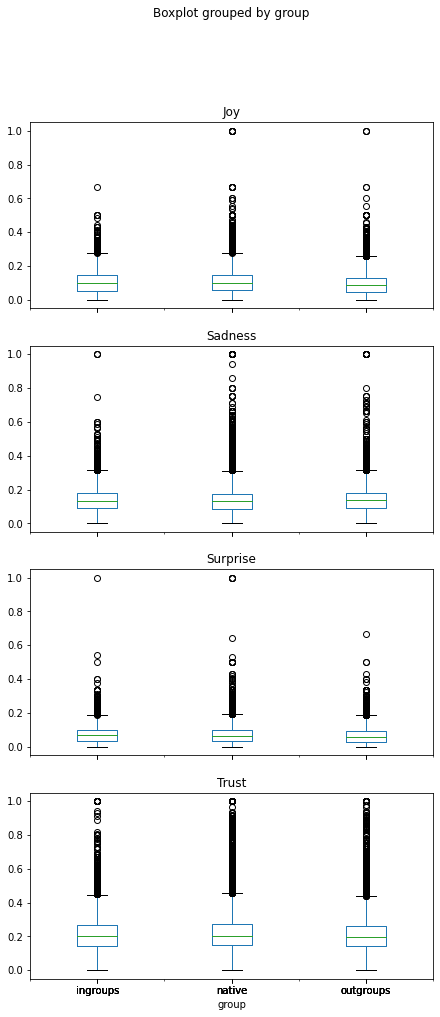

In [ ]:
# create boxplots for following 4 emotions

outgroups_df['group'] = 'outgroups'
ingroups_df['group'] = 'ingroups'
netherlands_nos['group'] = 'native'

myFig = plt.figure()

grouped_df = pd.concat([netherlands_nos, outgroups_df, ingroups_df])

boxplot = grouped_df.boxplot(column=[ 'Joy', 'Sadness', 'Surprise', 'Trust'], by='group',
                     layout=(5, 1), figsize = (7, 20) ,return_type='axes', grid=False)
plt.savefig("plots_and_tables/Sentiment_bPlots_second.png", format="png")
myFig.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

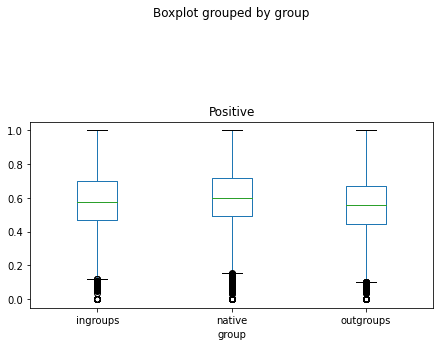

In [ ]:
# create boxplot for polarity score
outgroups_df['group'] = 'outgroups'
ingroups_df['group'] = 'ingroups'
netherlands_nos['group'] = 'native'

myFig = plt.figure()

grouped_df = pd.concat([netherlands_nos, outgroups_df, ingroups_df])

boxplot = grouped_df.boxplot(column=['Positive'], by='group',
                     layout=(5, 1), figsize = (7, 20) ,return_type='axes', grid=False)
plt.savefig("plots_and_tables/Sentiment_bPlots_Positive.png", format="png")
myFig.show()

In [ ]:
# normality testing with Shapiro-Wilk test
shapiro_table_sent = pd.DataFrame()
for country in [['native', netherlands_nos], ['outgroups', outgroups_df], ['ingroups', ingroups_df]]:
  c_df = country[1]
  e_scores_df = c_df[['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Negative', 'Positive', 'Sadness', 'Surprise', 'Trust']]

  for column in e_scores_df:
    print(('The Shapiro-Wilk test result for {} and column {} : {}').format(str(country[0]).replace('_nosnews.csv', ''), column, shapiro([item for item in e_scores_df[column] if not(math.isnan(item)) == True])))
    dicti = {'Group': [str(country[0])], 'Emotion': [column], 'Shapiro Statistic': [shapiro([item for item in e_scores_df[column] if not(math.isnan(item)) == True])[0]], 'p-value': [shapiro([item for item in e_scores_df[column] if not(math.isnan(item)) == True])[1]]}
    row_df = pd.DataFrame.from_dict(dicti)
    shapiro_table_sent = pd.concat([shapiro_table_sent, row_df], ignore_index=True)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test result for native and column Anger : (0.9551336765289307, 0.0)
The Shapiro-Wilk test result for native and column Anticipation : (0.9229575991630554, 0.0)
The Shapiro-Wilk test result for native and column Disgust : (0.8670532703399658, 0.0)
The Shapiro-Wilk test result for native and column Fear : (0.9645311236381531, 0.0)
The Shapiro-Wilk test result for native and column Joy : (0.9449247121810913, 0.0)
The Shapiro-Wilk test result for native and column Negative : (0.9928284287452698, 2.6064151436441598e-42)
The Shapiro-Wilk test result for native and column Positive : (0.9928455352783203, 2.8530436733653276e-42)
The Shapiro-Wilk test result for native and column Sadness : (0.9186595678329468, 0.0)
The Shapiro-Wilk test result for native and column Surprise : (0.9256006479263306, 0.0)
The Shapiro-Wilk test result for native and column Trust : (0.9028649926185608, 0.0)
The Shapiro-Wilk test result for outgroups and column Anger : (0.969579815864563, 0.0)
The Shap

In [ ]:
# store Shapiro-Wilk test results in table with rounded numbers
shapiro_table_sent.round(4)[['Emotion', 'Group', 'Shapiro Statistic', 'p-value']].to_csv('plots_and_tables/shapiro_table_sent.csv')

In [ ]:
shapiro_table_sent

,Group,Emotion,Shapiro Statistic,p-value
0,native,Anger,0.955134,0.000000e+00
1,native,Anticipation,0.922958,0.000000e+00
2,native,Disgust,0.867053,0.000000e+00
3,native,Fear,0.964531,0.000000e+00
4,native,Joy,0.944925,0.000000e+00
5,native,Negative,0.992828,2.606415e-42
6,native,Positive,0.992846,2.853044e-42
7,native,Sadness,0.918660,0.000000e+00
8,native,Surprise,0.925601,0.000000e+00
9,native,Trust,0.902865,0.000000e+00


In [ ]:
# list country df files
nos_dfs = [file for file in os.listdir() if '_nosnews.csv' in file]
country_dfs = [file for file in nos_dfs if 'groups' not in file]
group_dfs = [file for file in nos_dfs if 'groups' in file]

In [ ]:
# store every setiment value per country/ group in dictionaries
netherlands_sent = pd.read_csv('ethnic_subsets/netherlands_nosnews.csv').dropna().to_dict()
italy_sent = pd.read_csv('ethnic_subsets/italy_nosnews.csv').dropna().to_dict()
greece_sent = pd.read_csv('ethnic_subsets/greece_nosnews.csv').dropna().to_dict()
iran_sent = pd.read_csv('ethnic_subsets/iran_nosnews.csv').dropna().to_dict()
morocco_sent = pd.read_csv('ethnic_subsets/morocco_nosnews.csv').dropna().to_dict()
turkey_sent = pd.read_csv('ethnic_subsets/turkey_nosnews.csv').dropna().to_dict()
syria_sent = pd.read_csv('ethnic_subsets/syria_nosnews.csv').dropna().to_dict()
somalia_sent = pd.read_csv('ethnic_subsets/somalia_nosnews.csv').dropna().to_dict()
afghanistan_sent = pd.read_csv('ethnic_subsets/afghanistan_nosnews.csv').dropna().to_dict()

outgroups_sent = outgroups_df.dropna().to_dict()
ingroups_sent = ingroups_df.dropna().to_dict()


In [ ]:
# now for every country/ group the sentiment sepcific scores can be reached with dict[wanted emotion score]. Example:
len(netherlands_sent['Negative'])

57839

In [ ]:
# perform Kruskal-Wallis test, if alpha<.05, perform post-hoc Dunn test and print result
desc_sentiments = pd.DataFrame()
for col in ['Positive', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']:
  descriptives_native = [np.mean(netherlands_nos[col].dropna()), np.median(netherlands_nos[col].dropna()), np.std(netherlands_nos[col].dropna()), np.var(netherlands_nos[col].dropna()), len(netherlands_nos[col].dropna())]
  descriptives_out = [np.mean(outgroups_df[col].dropna()), np.median(outgroups_df[col].dropna()), np.std(outgroups_df[col].dropna()), np.var(outgroups_df[col].dropna()), len(outgroups_df[col].dropna())]
  descriptives_in = [np.mean(ingroups_df[col].dropna()), np.median(ingroups_df[col].dropna()), np.std(ingroups_df[col].dropna()), np.var(ingroups_df[col].dropna()), len(ingroups_df[col].dropna())]
  desc_sent = pd.DataFrame([descriptives_native, descriptives_out, descriptives_in], columns = ['Mean', 'Median', 'Standard Deviation', 'variance', 'Frequency'], dtype = float)
  desc_sent['Category'] = [col,col,col]
  desc_sent['Group'] = ['Native', 'Outgroup', 'Ingroup']
  # store descriptives per group and emotion in df
  desc_sentiments = pd.concat([desc_sentiments, desc_sent], ignore_index=True, axis=0)
  krus_test = kruskal(netherlands_nos[col].dropna().values, outgroups_df[col].dropna().values, ingroups_df[col].dropna().values)
  print(krus_test)
  if float(krus_test.pvalue) < .05:
    print('A Kruskal-Wallis test provided evidence of a difference (p < 0.05) between native, outgroup and ingroup ethnicities for', col)
    df = sp.posthoc_dunn([netherlands_nos[col].dropna().values, outgroups_df[col].dropna().values, ingroups_df[col].dropna().values], p_adjust = 'bonferroni')
    df.columns = ['Native', 'Outgroup', 'Ingroup']
    df.index = ['Native', 'Outgroup', 'Ingroup']
    print(df)

KruskalResult(statistic=1008.5624326744219, pvalue=9.850321768262376e-220)
A Kruskal-Wallis test provided evidence of a difference (p < 0.05) between native, outgroup and ingroup ethnicities for Positive
                 Native       Outgroup       Ingroup
Native     1.000000e+00  1.917924e-218  3.981118e-23
Outgroup  1.917924e-218   1.000000e+00  1.784898e-22
Ingroup    3.981118e-23   1.784898e-22  1.000000e+00
KruskalResult(statistic=955.6062981349467, pvalue=3.109774685854003e-208)
A Kruskal-Wallis test provided evidence of a difference (p < 0.05) between native, outgroup and ingroup ethnicities for Anger
                 Native       Outgroup       Ingroup
Native     1.000000e+00  2.568041e-209  9.552237e-12
Outgroup  2.568041e-209   1.000000e+00  2.734766e-34
Ingroup    9.552237e-12   2.734766e-34  1.000000e+00
KruskalResult(statistic=1200.5436361530897, pvalue=2.0195832836349435e-261)
A Kruskal-Wallis test provided evidence of a difference (p < 0.05) between native, outgroup and 

In [ ]:
desc_sentiments

,Mean,Median,Standard Deviation,variance,Frequency,Category,Group
0,0.598021,0.597270,0.167322,0.027997,57839.0,Positive,Native
1,0.559174,0.560000,0.171935,0.029562,26611.0,Positive,Outgroup
2,0.581755,0.578947,0.172883,0.029888,8252.0,Positive,Ingroup
3,0.080757,0.077670,0.042487,0.001805,57866.0,Anger,Native
4,0.089989,0.087231,0.045005,0.002025,26617.0,Anger,Outgroup
5,0.083941,0.081081,0.043648,0.001905,8253.0,Anger,Ingroup
6,0.103385,0.100418,0.049607,0.002461,57866.0,Anticipation,Native
7,0.093024,0.090737,0.048696,0.002371,26617.0,Anticipation,Outgroup
8,0.097335,0.095129,0.048842,0.002386,8253.0,Anticipation,Ingroup
9,0.032340,0.030151,0.027646,0.000764,57866.0,Disgust,Native


In [ ]:
desc_sentiments.to_csv('plots_and_tables/sentiment_descriptives.csv')